In [49]:
import itertools
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
from sklearn.preprocessing import StandardScaler, RobustScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [50]:
file_path = './dataset/'
train_fn = 'FordA_TRAIN.arff'
test_fn = 'FordA_TEST.arff'

def read_ariff(path):
    raw_data, meta = loadarff(path)
    cols = [x for x in meta]
    data2d = np.zeros([raw_data.shape[0], len(cols)])

    for i, col in zip(range(len(cols)), cols):
        data2d[:, i]=raw_data[col]
    return data2d

train =  read_ariff(file_path + train_fn)
test = read_ariff(file_path + test_fn)

In [51]:
print('train_set.shape:', train.shape)
print('test_set.shape:', test.shape)

train_set.shape: (3601, 501)
test_set.shape: (1320, 501)


In [52]:
x_train_temp = train[:,:-1]
y_train_temp = train[:,-1]

x_test = test[:, :-1]
y_test = test[:, -1]

In [53]:
normal_x = x_train_temp[y_train_temp==1]
abnormal_x = x_train_temp[y_train_temp==-1]
normal_y = y_train_temp[y_train_temp==1]
abnormal_y = y_train_temp[y_train_temp==-1]

x_train_normal, x_valid_normal, y_train_normal, y_valid_normal = train_test_split(
    normal_x, normal_y, test_size=0.2, random_state=42, stratify=normal_y)

x_train_abnormal, x_valid_abnormal, y_train_abnormal, y_valid_abnormal = train_test_split(
    abnormal_x, abnormal_y, test_size=0.2, random_state=42, stratify=abnormal_y)

x_train = np.concatenate((x_train_normal, x_train_abnormal), axis=0)
y_train = np.concatenate((y_train_normal, y_train_abnormal), axis=0)

x_valid = np.concatenate((x_valid_normal, x_valid_abnormal), axis=0)
y_valid = np.concatenate((y_valid_normal, y_valid_abnormal), axis=0)

In [54]:
print('x_train.shape:', x_train.shape)
print('x_valid.shape:', x_valid.shape)
print('y_train.shape:', y_train.shape)
print('y_valid.shape:', y_valid.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (2880, 500)
x_valid.shape: (721, 500)
y_train.shape: (2880,)
y_valid.shape: (721,)
x_test.shape: (1320, 500)
y_test.shape: (1320,)


## 2.데이터 전처리

#### 2.1 데이터 정규화

- 동일 시간 길이(3,600) 내 센서 값들이 넓은 범위로 퍼져있다.

- 변수 간의 Scale이 서로 다르기 때문에, 데이터를 그대로 학습하는 것은 적절하지 않다.

- 인풋 값들을 정규화(Normalization)을 한다.

- 흔히 공정 데이터에는 이상치(Outlier)가 발생할 수 있는데 강건한 정규화가 필요할 때 RobustScaler를 사용한다.

- StandScaler는 보다 더 일반적으로 사용하는 정규화 방법

    - 데이터를 단위 분산으로 조정함으로써 Outlier에 취약할 수 있음     

- RobustScaler는 Feature간 스케일을 갖게 되지만 평균과 분산 대신 중간 값(median)과 사분위값(quartile)을 사용 -> 극단값(Outlier)에 영향을 받지 않음

In [55]:
print("x_train shape:", x_train.shape)  # (num_samples, num_features)
print("x_valid shape:", x_valid.shape)  # (num_samples, num_features)

x_train shape: (2880, 500)
x_valid shape: (721, 500)


In [56]:
from sklearn.preprocessing import StandardScaler, RobustScaler

stder = StandardScaler()
stder.fit(x_train)
x_train = stder.transform(x_train)
x_valid = stder.transform(x_valid)

# rscaler = RobustScaler()
# rscaler.fit(x_train)
# x_train = rscaler.transform(x_train)
# x_valid = rscaler.transform(x_valid)

#### 2.2 데이터 형태 변환


In [57]:
y_train[y_train == -1] = 0
y_valid[y_valid == -1] = 0
y_test[y_test == -1] = 0

In [58]:
x_train_exp = np.expand_dims(x_train, -1)
x_valid_exp = np.expand_dims(x_valid, -1)
x_test_exp = np.expand_dims(x_test, -1)

# x_train_exp = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
# x_valid_exp = x_valid.reshape((x_valid.shape[0], x_valid.shape[1], 1))
# x_test_exp = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

print('x_train_exp의 형태:', x_train_exp.shape)
print('x_valid_exp의 형태:', x_valid_exp.shape)
print('x_test_exp의 형태:', x_test_exp.shape)

x_train_exp의 형태: (2880, 500, 1)
x_valid_exp의 형태: (721, 500, 1)
x_test_exp의 형태: (1320, 500, 1)


## 3.지표함수

##### (1) Confustion Matrix

In [59]:
from sklearn.metrics import classification_report, confusion_matrix

def draw_confusion_matrix(model, xt, yt, model_name):
    Y_pred = model.predict(xt)

    if model_name in ['cnn', 'rnn']:
        y_pred = np.argmax(Y_pred, axis=1)
    else: y_pred = Y_pred

    plt.figure(figsize=(3,3))
    cm = confusion_matrix(yt, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['False', 'True'], rotation=45)
    plt.yticks(tick_marks, ['False', 'True'])
    thresh = cm.max()/1.2
    normalize = False

    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                        horizontalalignment = 'center',
                        color = 'white' if cm[i, j] > thresh else 'black',
                        fontsize = 12)

    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{model_name}_cm.png', dpi=100, bbox_inches='tight')
    plt.show()

    print(classification_report(yt, y_pred))

##### (2) ROC Curve

In [60]:
from sklearn.metrics import roc_curve, auc

def draw_roc(model, xt, yt, model_name):
    Y_pred = model.predict(xt)

    if model_name in ['cnn', 'rnn']:
        y_pred = np.argmax(Y_pred, axis=1)
    else: y_pred = Y_pred

    fpr, tpr, thr = roc_curve(yt, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
                        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0,1],[0,1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {};'.format(model_name))
    plt.legend(loc='lower right')
    plt.ion()
    plt.tight_layout
    plt.savefig(f'{model_name}_roc.png', dpi=100, bbox_inches='tight')
    plt.show()

##### (3) Epoch에 따른 학습 & 검증의 손실(loss) 그래프


In [78]:
def plot_loss_graph(history, pic_name):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training & Validation Loss')
    plt.ylabel('loss', fontsize='large')
    plt.xlabel('epoch', fontsize='large')
    plt.legend(['train', 'validation'], loc='best')
    plt.tight_layout()
    plt.savefig(f'{pic_name}_loss.png', dpi=100, bbox_inches='tight')
    plt.show()

##### (4) Epoch에 따른 정확도(Accuracy Rate) 그래프

In [79]:
def plot_prediction_graph(history, pic_name):
    plt.figure()
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('model'+'Prediction Accuracy')
    plt.ylabel('sparse_categorical_accuracy', fontsize='large')
    plt.xlabel('epoch', fontsize='large')
    plt.legend(['train', 'validation'], loc='best')
    plt.tight_layout()
    plt.savefig(f'{pic_name}_auc.png', dpi=100, bbox_inches='tight')
    plt.show()

## 4. 모델 구축 및 설계

#### 4.3 순한 신경망(Recurrent Neural Network)

- RNN의 특성상 정보와 그 정보를 사용하는 지점 사이의 거리가 멀 경우, 역전파(Backpropagation)시 경사도(Gradient)값이 점차 줄어 해당 노드가 학습되지 않는 vanishing gradient problem이 발생

- 장단기 메모리 모델(Long Short Term Memory, LSTM) -> 기존의 RNN 계열 모델의 약점을 보완

- LSTM은 RNN의 숨겨진 상태(hidden state)에 셀 상태(cell-stte)를 추가한 구조
 

In [63]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, GlobalAveragePooling1D, Dense

# def make_rnn_model():
#     model = Sequential()
#     model.add(LSTM(units=256, return_sequences=True, input_shape=(500, 1)))
#     model.add(GlobalAveragePooling1D())
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(2, activation='softmax'))
#     return model

# rnn_model = make_rnn_model()

In [64]:
# from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# epochs = 100
# batch_size=64
# rnn_model.compile(loss='sparse_categorical_crossentropy',
#                   optimizer='adam',
#                   metrics=['sparse_categorical_accuracy']
#                 )

# callbacks = [ModelCheckpoint('rnn_best_model.keras',
#                             monitor='val_loss',
#                             save_best_only=True),
#             ReduceLROnPlateau(
#                 monitor='val_loss', factor=0.5, patience=20, min_lr=0.0001
#             ),
#             EarlyStopping(monitor='val_loss', patience=10, verbose=1)
#             ]

# history_rnn = rnn_model.fit(
#   x_train_exp,
#   y_train,
#   batch_size=batch_size,
#   epochs=epochs,
#   callbacks=callbacks,
#   validation_data=(x_valid_exp, y_valid),
#   verbose=1
# )

In [65]:
# from tensorflow.keras.models import load_model

# rnn_model = tf.keras.models.load_model('rnn_best_model.keras')
# scores = rnn_model.evaluate(x_test_exp, y_test)

# print('\n''Test accuracy', scores[1])
# print('\n''Test loss', scores[0])
# print('%s: %.2f%%'% (rnn_model.metrics_names[1], scores[1]*100))

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Attention, TimeDistributed
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, GlobalAveragePooling1D

def make_improved_rnn_model():
    inputs = Input(shape=(500, 1))
    x = LSTM(units=256, return_sequences=True)(inputs)
    x, forward_h, forward_c = LSTM(units=128, return_sequences=True, return_state=True)(x)
    
    # Attention 레이어를 추가
    attention = Attention()([x, x])  # query와 value를 동일하게 사용
    x = GlobalAveragePooling1D()(attention)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

improved_rnn_model = make_improved_rnn_model()

# 모델 컴파일
improved_rnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['sparse_categorical_accuracy']
)
/

callbacks = [
    ModelCheckpoint('improved_rnn_best_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001),
    EarlyStopping(monitor='val_loss', patience=15, verbose=1)
]


# 모델 학습
history_improved_rnn = improved_rnn_model.fit(
    x_train_exp, y_train,
    batch_size=64,  # 기본 배치 크기 유지
    epochs=100,
    callbacks=callbacks,
    validation_data=(x_valid_exp, y_valid),
    verbose=1
)

# 테스트 성능 평가
test_loss, test_accuracy = improved_rnn_model.evaluate(x_test_exp, y_test)
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")

# Bidirectional LSTM: 양방향 학습으로 패턴을 더 잘 학습하며, 이를 통해 성능 향상 기대.
# Attention Mechanism: 시계열 데이터에서 중요한 타임스텝에 집중하여, 예측 정확도를 더욱 높입니다.
# Dropout과 Batch Normalization: 모델의 일반화 성능을 높여 과적합을 방지합니다.
# 이와 같은 개선을 통해 테스트 데이터 정확도와 손실이 더욱 향상될 것으로 기대되며, 다양한 타임스텝에 대한 정보 학습 능력이 개선됩니다.

# Test accuracy: 0.9454545378684998
# Test loss: 0.1742297261953354

# def scheduler(epoch, lr):
#     if epoch < 10:  # 20 에포크 동안 유지
#         return lr
#     else:
#         return float(lr * tf.math.exp(-0.1))

# # 콜백 설정 (스케쥴러 포함)
# callbacks = [
#     ModelCheckpoint('improved_rnn_best_model.keras', monitor='val_loss', save_best_only=True),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001),
#     EarlyStopping(monitor='val_loss', patience=15, verbose=1),
#     # LearningRateScheduler(scheduler)  # 추가된 학습률 스케쥴러 콜백
# ]
# Test accuracy: 0.935606062412262
# Test loss: 0.16969677805900574

# Test accuracy: 0.9340909123420715
# Test loss: 0.21929402649402618

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 0.6938 - sparse_categorical_accuracy: 0.5194 - val_loss: 0.6869 - val_sparse_categorical_accuracy: 0.5132 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - loss: 0.6724 - sparse_categorical_accuracy: 0.5694 - val_loss: 0.6550 - val_sparse_categorical_accuracy: 0.6505 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - loss: 0.6908 - sparse_categorical_accuracy: 0.5558 - val_loss: 0.6253 - val_sparse_categorical_accuracy: 0.6727 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 0.6136 - sparse_categorical_accuracy: 0.6547 - val_loss: 0.5522 - val_sparse_categorical_accuracy: 0.6949 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 0.5447 - sparse_categorical_accuracy: 0.7068 - val_loss: 0.5404 - val_sparse_categorical_accuracy: 0.7143 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - lo

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Model

# 모델 구성
def make_optimized_rnn_model():
    inputs = Input(shape=(500, 1))
    x = Bidirectional(LSTM(units=128, return_sequences=True))(inputs)
    x = Dropout(0.3)(x)  # Dropout 추가
    x = Bidirectional(LSTM(units=64, return_sequences=True))(x)
    x = Dropout(0.3)(x)  # Dropout 추가
    x = GlobalAveragePooling1D()(x)
    x = Dense(50, activation='relu')(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(inputs, x)
    return model

optimized_rnn_model = make_optimized_rnn_model()

# 모델 컴파일
optimized_rnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # 더 낮은 학습률
    metrics=['sparse_categorical_accuracy']
)

# 콜백 설정 (patience 조정)
callbacks = [
    ModelCheckpoint('optimized_rnn_best_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001),
    EarlyStopping(monitor='val_loss', patience=20, verbose=1)  # patience 증가
]

# 모델 학습
history_optimized_rnn = optimized_rnn_model.fit(
    x_train_exp, y_train,
    batch_size=64,
    epochs=100,
    callbacks=callbacks,
    validation_data=(x_valid_exp, y_valid),
    verbose=1
)

# 테스트 성능 평가
test_loss, test_accuracy = optimized_rnn_model.evaluate(x_test_exp, y_test)
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - loss: 0.6937 - sparse_categorical_accuracy: 0.4806 - val_loss: 0.6939 - val_sparse_categorical_accuracy: 0.5132 - learning_rate: 5.0000e-04
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - loss: 0.6930 - sparse_categorical_accuracy: 0.5152 - val_loss: 0.6913 - val_sparse_categorical_accuracy: 0.5132 - learning_rate: 5.0000e-04
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - loss: 0.6735 - sparse_categorical_accuracy: 0.5616 - val_loss: 0.5555 - val_sparse_categorical_accuracy: 0.7060 - learning_rate: 5.0000e-04
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - loss: 0.5672 - sparse_categorical_accuracy: 0.7017 - val_loss: 0.5331 - val_sparse_categorical_accuracy: 0.7198 - learning_rate: 5.0000e-04
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - loss: 0.5463 - sparse_categorical_accuracy: 0.7079 - val_loss: 0.5398 - val_sparse_categorical_accuracy: 0.7032 - learning_rate: 5.0000e-04
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━

#### (1) Confusion Matrix

In [84]:
def draw_confusion_matrix(model, xt, yt, model_name):
    Y_pred = model.predict(xt)
    
    # 이진 분류를 위한 확률을 클래스로 변환
    y_pred = np.argmax(Y_pred, axis=1) if Y_pred.shape[1] > 1 else (Y_pred > 0.5).astype("int32")

    plt.figure(figsize=(3,3))
    cm = confusion_matrix(yt, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['False', 'True'], rotation=45)
    plt.yticks(tick_marks, ['False', 'True'])
    thresh = cm.max() / 2
    fmt = 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{model_name}_cm.png', dpi=100, bbox_inches='tight')
    plt.show()
    print(classification_report(yt, y_pred))

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step


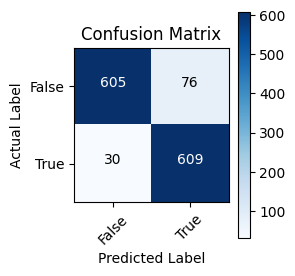

              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92       681
         1.0       0.89      0.95      0.92       639

    accuracy                           0.92      1320
   macro avg       0.92      0.92      0.92      1320
weighted avg       0.92      0.92      0.92      1320



In [85]:
draw_confusion_matrix(optimized_rnn_model, x_test_exp, y_test, 'optimized_rnn')

#### (2) ROC Curve

In [87]:
def draw_roc(model, xt, yt, model_name):
    Y_pred = model.predict(xt)
    
    # 양성 클래스(클래스 1)의 확률만 가져옵니다
    y_pred_proba = Y_pred[:, 1] if Y_pred.shape[1] > 1 else Y_pred

    fpr, tpr, thr = roc_curve(yt, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(f'{model_name}_roc.png', dpi=100, bbox_inches='tight')
    plt.show()

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step


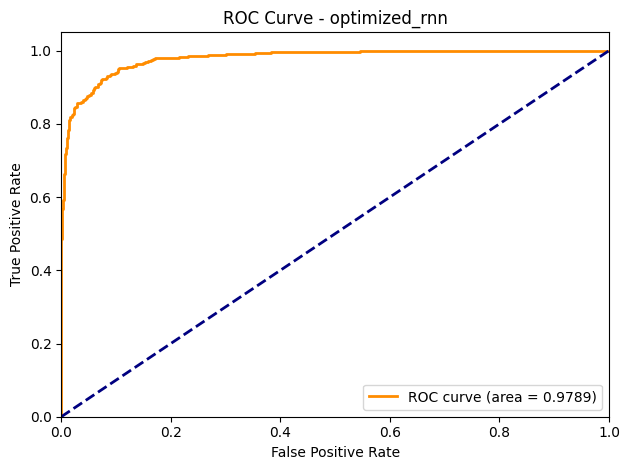

In [88]:
draw_roc(optimized_rnn_model, x_test_exp, y_test, 'optimized_rnn')

#### (3) Learning Curve: Epoch에 따른 학습, 검증 손실 (Loss) 추이

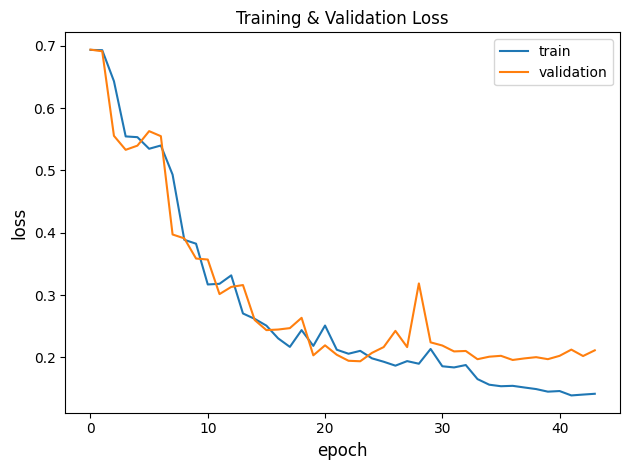

In [86]:
plot_loss_graph(history_optimized_rnn, 'optimized_rnn')

#### (4) Learning Curve: Epoch에 따른 학습, 검증 정확도 추이

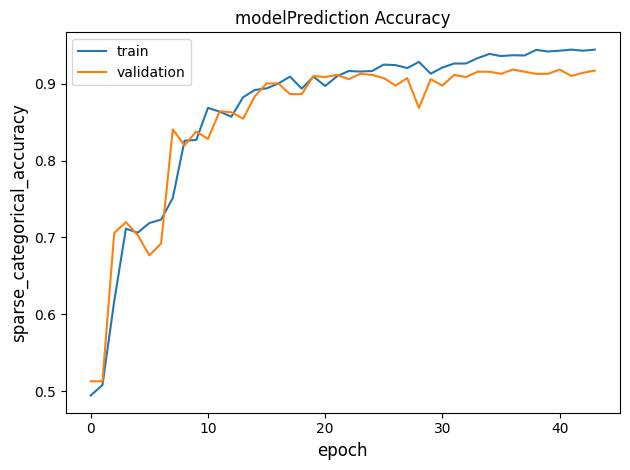

In [89]:
plot_prediction_graph(history_optimized_rnn, 'optimized_rnn')